# Overview



In [1]:
#Core imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from collections import Counter 

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /Users/joyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#Import data

data = pd.read_csv('../ads/Advertisement_Transcripts.csv')

In [3]:
#explore data
data.info()

#5 columns with 1,9935 enties 
#the label column is blank and will be dropped for exploration 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936 entries, 0 to 1935
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         1935 non-null   object 
 1   Advertiser       1935 non-null   object 
 2   Product_or_spot  1935 non-null   object 
 3   Ad_copy          1935 non-null   object 
 4   label            0 non-null      float64
dtypes: float64(1), object(4)
memory usage: 75.8+ KB


In [4]:
if 'label' in data.columns:
    data.drop(columns='label', inplace= True)

data.head()

,Category,Advertiser,Product_or_spot,Ad_copy
0,Advocacy,23 Women,23 Women,Women make up seventy percent of the labor for...
1,Advocacy,AARP,AARP,It's right in your own backyard.\nWhile it may...
2,Advocacy,Above the Influence,Above the Influence (PSA),"I thought I respected myself. That is, until I..."
3,Advocacy,Adopt-A-Horse,Adopt-A-Horse,If there's a place in your heart for a wild mu...
4,Advocacy,Amberalert.org,Amberalert.org,"When someone abducts a child, they're not abou..."


In [5]:
#Checking for blank rows 

# show blank rows
blank_df = data.isnull().any(axis=1)
blank_rows = data[blank_df]
print(blank_rows)

# drop row 1935 
if 1935 in data.index:
    if data.loc[1935].isnull().all():
        data.drop(index=1935, inplace=True)

print('Updated number of blank rows:\n', data.isnull().sum())

     Category Advertiser Product_or_spot Ad_copy
1935      NaN        NaN             NaN     NaN
Updated number of blank rows:
 Category           0
Advertiser         0
Product_or_spot    0
Ad_copy            0
dtype: int64


In [6]:
#Explore groups
category_counts = data['Category'].value_counts()


# print the results
print('Category counts:\n', category_counts)



Category counts:
 Automotive               289
Food & Beverage          244
Home & Personal Care     215
Travel                   193
Advocacy                 156
Financial                142
Beauty                   103
Services                  98
Media & Entertainment     74
Health Care               73
Alcohol & Spirits         64
Restaurants               54
Retail                    47
Telecommunications        44
Insurance                 43
Education                 24
Electronics               16
Technology                13
Sports                    12
Residential               11
Political                  8
Agricultural               5
Appliances                 5
HeaLth Care                2
Name: Category, dtype: int64


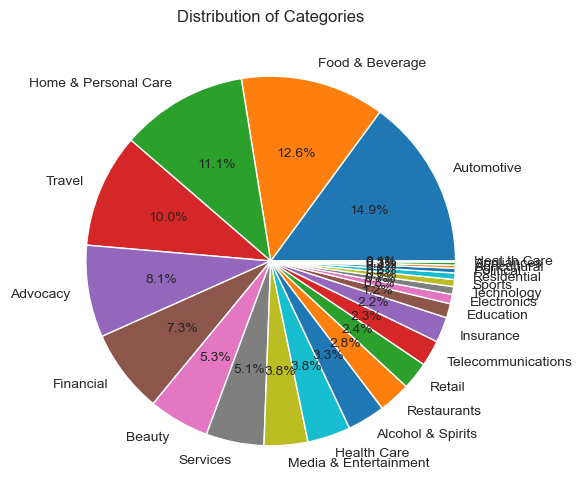

In [7]:
#Visual look at catorgires 
sns.set_style('whitegrid')
plt.figure(figsize=(6, 6))
plt.title('Distribution of Categories')
sns.color_palette('pastel')
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
plt.show()

In [8]:
#Check for duplicates
print(data.describe(include='all'))

#There are 26 duplicates
duplicate_= data.duplicated(subset=['Ad_copy']).sum()

print(f"There are {duplicate_} duplicates in the 'Ad_copy' column.")

if duplicate_ > 0:
    data.drop_duplicates(subset=['Ad_copy'], inplace=True, keep='first')
    dups_= data.duplicated(subset=['Ad_copy']).sum()
    print(f"Now there are {dups_} duplicates in the 'Ad_copy' column.")

          Category Advertiser                      Product_or_spot  \
count         1935       1935                                 1935   
unique          24       1348                                 1904   
top     Automotive       AT&T  Revlon High Demension Color Accents   
freq           289         19                                    2   

                                                  Ad_copy  
count                                                1935  
unique                                               1909  
top     Sure, you're working hard to retire early. But...  
freq                                                    2  
There are 26 duplicates in the 'Ad_copy' column.
Now there are 0 duplicates in the 'Ad_copy' column.


Thinking 

The plan was to drop all the coulmn expct for the ad copy but it would be intesrestin to see the ratio of words in relation to the catorgy. 

#Cleaning Data

In [9]:
#Drop columns not needed
if 'Advertiser' in data.columns:
    data.drop(columns='Advertiser', inplace= True)
if 'Product_or_spot' in data.columns:
    data.drop(columns='Product_or_spot', inplace= True)

data.head()

,Category,Ad_copy
0,Advocacy,Women make up seventy percent of the labor for...
1,Advocacy,It's right in your own backyard.\nWhile it may...
2,Advocacy,"I thought I respected myself. That is, until I..."
3,Advocacy,If there's a place in your heart for a wild mu...
4,Advocacy,"When someone abducts a child, they're not abou..."


In [10]:
#Add feature for length of tweet and number of words in text
data['word_count'] = data['Ad_copy'].apply(lambda x: len(str(x).split()))
data.head(5)

,Category,Ad_copy,word_count
0,Advocacy,Women make up seventy percent of the labor for...,75
1,Advocacy,It's right in your own backyard.\nWhile it may...,108
2,Advocacy,"I thought I respected myself. That is, until I...",42
3,Advocacy,If there's a place in your heart for a wild mu...,161
4,Advocacy,"When someone abducts a child, they're not abou...",40


        word_count
count  1909.000000
mean     63.166056
std      37.251555
min       4.000000
25%      40.000000
50%      57.000000
75%      77.000000
max     389.000000


<AxesSubplot:title={'center':'Word Count Distribution'}, ylabel='Frequency'>

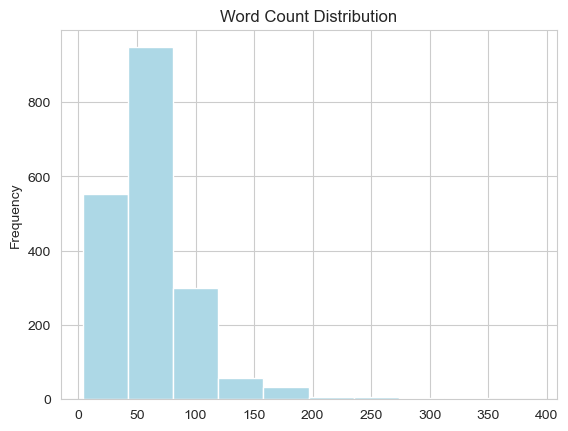

In [11]:
print(data.describe())


data['word_count'].plot(
    kind='hist',
    bins=10,
    color='lightblue',
    title='Word Count Distribution')

The range of text length is wide from 4 words to 389 words. 

<AxesSubplot:title={'center':'Top 20 words'}, xlabel='word'>

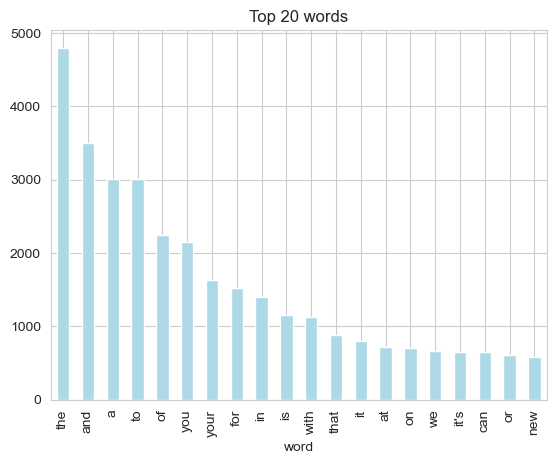

In [12]:
all_words = []
for line in list(data['Ad_copy']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
a=Counter(all_words).most_common(20)



df1 = pd.DataFrame(Counter(all_words).most_common(20), columns = ['word' , 'count'])
df1.groupby('word').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', y='Count', color='lightblue', title='Top 20 words')

#top words seem to be filler words

In [13]:
#looking for other option that would need to be removed 

random_sample = data.sample(n=5)
pd.set_option('display.max_colwidth', 1000)

# print the random sample
print(random_sample['Ad_copy'].to_string(index=False))

#\n 
#numbers eg 1-800-232-2522
#call - as ads were spoke out word adds no context
#website .com/ FloodSmart.gov/info
#$ and any other money related signs $49.95
#% 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Today's consumers and agents expect that buying life or health insurance should be as simple as buying anything else.\nThey want an easy pass through paperwork and medical tests straight to what they need.
                                                                                                                                                                                                                                                   

In [14]:


#removing numbers and adding column
data['new_copy'] = data.Ad_copy.str.replace("[^a-zA-Z#]", " ")

#Tokenization 
data['new_copy'] = data['new_copy'].apply(lambda x: x.split())

#removing stop words 
stop_words = set(stopwords.words('english'))

#need to keep genreded words 
not_stopwords = {'she', 'her', 'hers', 'herself', 'he', 'him', 'his', 'himself'} 
final_stop_words = set([word for word in stop_words if word not in not_stopwords])

def remove_stopwords(token):
  txt_clean = [word for word in token if word not in final_stop_words]
  return txt_clean


data['new_copy'] = data['new_copy'].apply(lambda x: remove_stopwords(x))

data.head()


/var/folders/j5/r409ppjn0fq15jv6zjmzjwfm0000gn/T/ipykernel_2558/3736126276.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['new_copy'] = data.Ad_copy.str.replace("[^a-zA-Z#]", " ")


,Category,Ad_copy,word_count,new_copy
0,Advocacy,"Women make up seventy percent of the labor force in Uganda, yet rarely get the chance to bring their own products to market. 23 Women is a real story of real women who saw the need to join together, work hard, and deliver the best coffee their country could offer.\nRated the number one coffee in Uganda at the AFCA Taste of Harvest Competition, these women produce some of the best coffee in the world.",75,"[Women, make, seventy, percent, labor, force, Uganda, yet, rarely, get, chance, bring, products, market, Women, real, story, real, women, saw, need, join, together, work, hard, deliver, best, coffee, country, could, offer, Rated, number, one, coffee, Uganda, AFCA, Taste, Harvest, Competition, women, produce, best, coffee, world]"
1,Advocacy,"It's right in your own backyard.\nWhile it may be hard to believe, roughly five million Americans don't even know where their next meal will come from.\nIn communities just like yours, there are many who need help.\nJoin people across the country who are coming together with AARP Create the Good, to end hunger.\nStart today. It can be as easy as giving food or money to your local area food bank, or getting tips to start your own food drive.\nWhatever level of involvement is right for you, we've made it simple to find and help people in your area.\nSo get involved. Go to www.createthegood.org/hunger.",108,"[It, right, backyard, While, may, hard, believe, roughly, five, million, Americans, even, know, next, meal, come, In, communities, like, many, need, help, Join, people, across, country, coming, together, AARP, Create, Good, end, hunger, Start, today, It, easy, giving, food, money, local, area, food, bank, getting, tips, start, food, drive, Whatever, level, involvement, right, made, simple, find, help, people, area, So, get, involved, Go, www, createthegood, org, hunger]"
2,Advocacy,"I thought I respected myself. That is, until I saw myself get high. It's just an ugly side of myself that I didn't recognize. Saying and doing things that just weren't me. I do respect myself, that's why I don't do drugs.",42,"[I, thought, I, respected, That, I, saw, get, high, It, ugly, side, I, recognize, Saying, things, I, respect, I, drugs]"
3,Advocacy,"If there's a place in your heart for a wild mustang or burro...and you're ready to adopt... come to Ingalls Park in Norco this Saturday and Sunday.\nThe Bureau of Land Management will offer 80 wild horses and 20 wild burros to qualified adopters through its Adopt-A-Horse or Burro Program.\nThese beautiful mustangs and burros were gathered from public lands in California, and they're in excellent health. They arrive at the park around noon on Friday and will be available for public viewing.\nMustangs are renowned for their strength, speed and endurance. Burros make excellent pets, companion animals and guard animals.\nThe minimum bid is only $125 dollars per animal. Fees may be paid by cash, check, or credit card.\nDon't miss this opportunity to adopt a wild mustang or burro this weekend at Ingalls Park in Norco.\nFor more information call eight hundred, nine five one, eight seven two zero. That's eight hundred, nine five one, eight seven two zero.",161,"[If, place, heart, wild, mustang, burro, ready, adopt, come, Ingalls, Park, Norco, Saturday, Sunday, The, Bureau, Land, Management, offer, wild, horses, wild, burros, qualified, adopters, Adopt, A, Horse, Burro, Program, These, beautiful, mustangs, burros, gathered, public, lands, California, excellent, health, They, arrive, park, around, noon, Friday, available, public, viewing, Mustangs, renowned, strength, speed, endurance, Burros, make, excellent, pets, companion, animals, guard, animals, The, minimum, bid, dollars, per, animal, Fees, may, paid, cash, check, credit, card, Don, miss, opportunity, adopt, wild, mustang, burro, weekend, Ingalls, Park, Norco, For, information, call, eight, hundred, nine, five, one, eight, seven, two, zero, That, eight, ...]"


In [15]:
#Words mixture of relvent inclusive and non-inclsive words. Words were source from vasious location 



masculine_words = [
    "active",
    "adventurous",
    "aggress",
    "ambitio",
    "analy",
    "assert",
    "athlet",
    "autonom",
    "battle",
    "boast",
    "challeng",
    "champion",
    "compet",
    "confident",
    "courag",
    "decid",
    "decision",
    "decisive",
    "defend",
    "determin",
    "domina",
    "dominant",
    "driven",
    "fearless",
    "fight",
    "force",
    "greedy",
    "head-strong",
    "headstrong",
    "hierarch",
    "hostil",
    "impulsive",
    "independen",
    "individual",
    "intellect",
    "lead",
    "logic",
    "objective",
    "opinion",
    "outspoken",
    "persist",
    "principle",
    "reckless",
    "self-confiden",
    "self-relian",
    "self-sufficien",
    "selfconfiden",
    "selfrelian",
    "selfsufficien",
    "stubborn",
    "superior",
    "unreasonab"
]

feminine_words = [
    "agree",
    "affectionate",
    "child",
    "cheer",
    "collab",
    "commit",
    "communal",
    "compassion",
    "connect",
    "considerate",
    "cooperat",
    "co-operat",
    "depend",
    "emotiona",
    "empath",
    "feel",
    "flatterable",
    "gentle",
    "honest",
    "interpersonal",
    "interdependen",
    "interpersona",
    "inter-personal",
    "inter-dependen",
    "inter-persona",
    "kind",
    "kinship",
    "loyal",
    "modesty",
    "nag",
    "nurtur",
    "pleasant",
    "polite",
    "quiet",
    "respon",
    "sensitiv",
    "submissive",
    "support",
    "sympath",
    "tender",
    "together",
    "trust",
    "understand",
    "warm",
    "whin",
    "enthusias",
    "inclusive",
    "yield",
    "share",
    "sharin"
]

gendered_words = [
    "Actor",
    "Actress",
    "male",
    "man",
    "master",
    "Bogeyman",
    "Boogeyman",
    "Businessman",
    "Businessmen",
    "Chairman",
    "Congressman",
    "Crone",
    "sir"
    "madam",
    "Female",
    "Fireman",
    "Gals",
    "Girl",
    "Girls",
    "Guys",
    "Hag",
    "Housekeeping",
    "Ladies",
    "gentlemen",
    "Ladies room",
    "Lady",
    "Lady time",
    "Ladylike",
    "Mailman",
    "Man hours",
    "Man made",
    "Man up",
    "Mankind",
    "Manpower",
    "Mastered",
    "Mastering",
    "Old geezer",
    "Policeman",
    "Postman",
    "Prostitute",    
    "Skank",    
    "Skanky",    
    "Slut",    
    "Steward",    
    "Stewardess",    
    "Stewardesses",    
    "The common man",    
    "Tramp",    
    "Whore"]

masculine_pronouns = ['he', 'him', 'his', 'himself', 'man', 'men', 'male', 'father', 'brother', 'son', 'uncle', 'grandfather', 'nephew', 'husband', 'boyfriend', 'groom', 'king', 'prince', 'emperor', 'sir', 'lord']

feminine_pronouns = ['she', 'her', 'hers', 'herself', 'woman', 'women', 'female', 'mother', 'sister', 'daughter', 'aunt', 'grandmother', 'niece', 'wife', 'girlfriend', 'bride', 'queen', 'princess', 'empress', 'lady', 'madam']



In [16]:
# Pick the text 
text = data['Ad_copy'].sample().iloc[0]

# check if any feminine words are in the text
fem_words = [word for word in feminine_words if word in text.lower()]
fem_in_text = len(fem_words)

# check if any masculine words are in the text
masc_words = [word for word in masculine_words if word in text.lower()]
masc_in_text = len(masc_words)

# check if any gendered words are in the text
maspro_words = [word for word in masculine_pronouns if word in text.lower()]
fempro_words = [word for word in feminine_pronouns if word in text.lower()]
gen_in_text = len(maspro_words) + len(fempro_words)

# print the results
print('Feminine words in text:', fem_in_text)
print('Masculine words in text:', masc_in_text)
print('Gendered words in text:', gen_in_text)
print('Pronouns words in text: fem', len(fempro_words), 'male', len(maspro_words))
print('Feminine words found:', fem_words)
print('Masculine words found:', masc_words)
print('Gendered words found:', maspro_words + fempro_words)
print(text)


Feminine words in text: 1
Masculine words in text: 0
Gendered words in text: 3
Pronouns words in text: fem 1 male 2
Feminine words found: ['depend']
Masculine words found: []
Gendered words found: ['he', 'king', 'her']
At Hampton Chevrolet, teamwork is what we're all about. And that means better service to you. Dependable people who go out of their way...to get you the best car at a bottom line price. At Hampton Chevrolet, when we say "We're Your Team" we're talking about a long tradition of teamwork and reliability...we're here to keep people happy long after you buy your car. So when it comes to buying your next car or van...know that you've got a team that's going to bat for you...long after you drive away. HAMPTON CHEVROLET.


Version one notes
- It was flag word I could not see in the text. add the the words flagged and found it was picking up parts of words. 
- Thinking: clean filler words and tokenizse text. not sure if steeming needed at this stage 
- I still need to understand the output in order to label it so will add a coloumn to dataset 